# Self-Attention: Building the Foundation of Transformers

## Understanding Attention Through Implementation

In this notebook, you'll build self-attention from scratch to understand the mechanism that revolutionized natural language processing. Rather than treating attention as a black box, you'll see exactly how it computes relationships between words, why it's so powerful, and how it learns to focus on relevant context.

Self-attention is the core innovation that enables models like BERT, GPT, and other transformers to understand language. By the end of this notebook, you'll have implemented the same attention mechanism used in these state-of-the-art models, working through simple examples to build deep intuition about how and why it works.

Let's demystify attention by coding each component step by step, visualizing the computations, and seeing how different patterns emerge from the learning process.

## 1 - Data Preparation

### 1.1 Introduction

Before you can train any language model, you need to convert raw text into a numerical format that the model can understand. This fundamental step transforms human-readable text into the mathematical representations that neural networks require.

You'll start by preparing a **toy dataset**: just a few simple sentences. This small scale lets you trace through every computation and truly understand what's happening inside the attention mechanism.

As part of this process, you'll build a vocabulary that includes:
- A **padding token** (`<pad>`) for making all sequences the same length in a batch
- An **unknown token** (`<unk>`) to handle any rare or out-of-vocabulary words the model might encounter

These special tokens are essential for handling real-world text where sequences vary in length and new words may appear during inference.

Let's begin!

In [1]:
import math
import os
import re
import urllib.request
from collections import Counter
from typing import Callable, Dict, List, Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
# 1. Tiny toy dataset
sentences = """
the dog chased the cat
the cat chased the mouse
the dog ran fast
the mouse ran fast
the cat lay down
"""

# Build vocab
tokens = sentences.split()
vocab = ['<pad>', '<unk>'] + sorted(set(tokens))
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}
print("Vocab:", vocab)

Vocab: ['<pad>', '<unk>', 'cat', 'chased', 'dog', 'down', 'fast', 'lay', 'mouse', 'ran', 'the']


### 1.2 The Tokenizer

A fundamental step in any NLP pipeline is **tokenization**. A tokenizer splits raw text into meaningful chunks (tokens)—typically words—that become the basic units your model processes. Since neural networks work with numbers, not text, the tokenizer also handles the crucial task of mapping these tokens to unique numerical IDs.

Below, you'll define a simple Python tokenizer as a class. This version uses regular expressions to extract whole words while normalizing the text by:
- Converting everything to lowercase for consistency
- Removing punctuation to focus on word meanings
- Splitting on whitespace and word boundaries

This clean, simplified approach is perfect for understanding attention mechanics without getting distracted by complex linguistic edge cases.

In [3]:
class SimpleTokenizer:
    """Splits on whitespace and lowercases, with optional regex for real word tokens."""
    def __init__(self):
        pass

    def __call__(self, text):
        # Option 1: Basic split (uncomment to just split on spaces)
        # return text.lower().split()
        # Option 2: More robust - returns only word tokens (ignores punctuation)
        return re.findall(r'\b\w+\b', text.lower())

# Usage example:
tokenizer = SimpleTokenizer()
tokens = tokenizer("The Dog chased the Cat.")
print(tokens)  # Output: ['the', 'dog', 'chased', 'the', 'cat']

['the', 'dog', 'chased', 'the', 'cat']


### 1.3 Building the Vocabulary

Once you have a tokenizer that splits your sentences into individual words, the next step is to build a **vocabulary**—a list of all unique tokens that appear in your dataset.

This vocabulary is crucial because it links each word to a unique ID, which your model will use throughout training and inference. You'll also want to include two special tokens in your vocabulary: one for padding (`<pad>`) and one for unknown or out-of-vocabulary tokens (`<unk>`).

Below you'll find a function to create:
- the vocabulary list,
- a dictionary that maps each token to its unique index (**word2idx**),
- and a reverse mapping from indices to words (**idx2word**).

You can adjust the `min_freq` parameter to exclude rare words and keep your vocabulary more manageable.

In [4]:
def build_vocab(sentences, tokenizer, min_freq=1):
    counter = Counter()  # Counter to count word frequencies in all sentences
    for sent in sentences:
        counter.update(tokenizer(sent))  # Tokenize sentence and add token counts

    # Start vocab with special tokens, then add words meeting min_freq threshold
    vocab = ['<pad>', '<unk>'] + [w for w, c in counter.items() if c >= min_freq]

    # Create a mapping from word to unique index
    word2idx = {w: i for i, w in enumerate(vocab)}

    # Create a mapping from index back to word (inverse of word2idx)
    idx2word = {i: w for i, w in enumerate(vocab)}

    # Return the vocab list and the two dictionaries
    return vocab, word2idx, idx2word

# Using our sample sentences and tokenizer
sentences = [
    "the dog chased the cat",
    "the cat chased the mouse",
    "the dog ran fast",
    "the mouse ran fast",
    "the cat lay down"
]

tokenizer = SimpleTokenizer()                 # Define the tokenizer (splits into lowercase words)
vocab, word2idx, idx2word = build_vocab(sentences, tokenizer)  # Build vocab & mappings

print(vocab)

['<pad>', '<unk>', 'the', 'dog', 'chased', 'cat', 'mouse', 'ran', 'fast', 'lay', 'down']


In [5]:
word = 'dog'
id_word = word2idx[word]
print(f"ID for word = {word}: {id_word}")
print(f"Word for ID = {id_word}: {idx2word[id_word]}")

ID for word = dog: 3
Word for ID = 3: dog


### 1.4 Sliding Windows

Now that you have a list of tokenized and numericalized sentences, you need to organize your data into **(input, target)** pairs suitable for training a language model.

The most common approach for this is to use a **sliding window**: you select a fixed-size window of words as input, and train the model to predict the next word that follows the window. By moving this window across every sentence in your dataset, you generate many (input, target) examples for training.

This method helps your model learn the sequential structure of language, so it can anticipate what comes next given a context. For example:

| Step | Input                              | Target  |
|------|------------------------------------|---------|
|  1   | the, dog, chased, the              | cat     |
|  2   | dog, chased, the, cat              | quickly |

Now you'll implement this sliding window approach in code. This will prepare your input and target lists, ready for training your attention-based model.

In [6]:
tokenizer = SimpleTokenizer()
vocab, word2idx, idx2word = build_vocab(sentences, tokenizer)

# 2. Parameters
SEQ_LEN = 4   # Length of input sequence for each example

# 3. Convert sentences to token ID lists
encoded_sentences = []  # Will be a list of lists of token IDs
for sent in sentences:
    tokens = tokenizer(sent)  # Split sentence into tokens
    ids = [word2idx.get(tok, word2idx['<unk>']) for tok in tokens]  # Map tokens to IDs
    encoded_sentences.append(ids)

# 4. Create sliding window dataset (inputs, targets)
inputs = []
targets = []
for ids in encoded_sentences:
    # For each possible window in the sentence
    for i in range(len(ids) - SEQ_LEN):
        window = ids[i:i+SEQ_LEN]        # Input: SEQ_LEN-token window
        target = ids[i+SEQ_LEN]          # Target: next token after the window
        inputs.append(window)
        targets.append(target)

# 5. Let's show the dataset as text for illustration
for inp, tgt in zip(inputs, targets):
    inp_words = [idx2word[i] for i in inp]
    tgt_word = idx2word[tgt]
    print(f"Input: {inp_words}  →  Target: {tgt_word}")

Input: ['the', 'dog', 'chased', 'the']  →  Target: cat
Input: ['the', 'cat', 'chased', 'the']  →  Target: mouse


### 1.5 Turning the Data Into a PyTorch Dataset

Now that you’ve prepared your `inputs` and `targets` lists, it’s time to convert them into a format that PyTorch can use for training: a `Dataset`.

A PyTorch `Dataset` is a simple class structure that knows how to return an input–target pair given an index. This makes it easy to batch your data and feed it into a model, especially for larger sets of examples.

Below, you’ll see how to wrap your lists in a `Dataset`, and then use a `DataLoader` to shuffle and batch your data automatically during training.

In [7]:
class TinyDataset(Dataset):
    def __init__(self, inputs, targets):
        # Convert your list of input windows to a PyTorch tensor (for fast indexing)
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        # Convert your target word indices to a PyTorch tensor
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a tuple (input_window, target_word) for the given index
        return self.inputs[idx], self.targets[idx]

# Create an instance of your dataset
dataset = TinyDataset(inputs, targets)

# Create a DataLoader that will feed batches of data to your model during training.
# batch_size=4: each batch will contain 4 (input, target) pairs
# shuffle=True: randomize order each epoch to improve training
# num_workers=0: no extra processes for loading data (good for small datasets)
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

## 2 - Manual Self-Attention

### 2.1 Introduction

Now you'll dig into the heart of what makes Transformers powerful: **self-attention**.

#### What is Self-Attention?

Self-attention is a mechanism that allows each word in a sequence to "look at" and "gather information from" every other word, including itself. Unlike traditional sequential models that process words one by one, self-attention computes relationships between all words simultaneously.

Think of it this way: when you read the sentence "The cat sat on the mat because it was tired," your brain automatically knows that "it" refers to "cat." Self-attention gives neural networks this same capability to understand relationships and dependencies between words, no matter how far apart they are.

#### The Self-Attention Algorithm

Here's how self-attention transforms a sequence:

```
Input: "The cat sat"
         ↓
   [Embeddings]
         ↓
   Q, K, V Projections
         ↓
   Attention Scores (Q × K^T)
         ↓
   Attention Weights (Softmax)
         ↓
   Weighted Sum (Weights × V)
         ↓
Output: Context-aware representations
```

#### The Core Components

Self-attention operates through three learned transformations of your input:

1. **Queries (Q)**: "What information am I looking for?"
   - Each word generates a query vector representing what it wants to know

2. **Keys (K)**: "What information do I contain?"
   - Each word generates a key vector advertising what information it has

3. **Values (V)**: "What information will I actually provide?"
   - Each word generates a value vector containing its actual contribution

#### The Attention Computation Flow

```
Step 1: Linear Projections
Input → W_Q → Queries
Input → W_K → Keys  
Input → W_V → Values

Step 2: Similarity Scores
Scores = Q × K^T / √d_k
(How relevant is each word to every other word?)

Step 3: Attention Weights  
Weights = Softmax(Scores)
(Convert scores to probabilities)

Step 4: Weighted Aggregation
Output = Weights × V
(Combine values based on attention weights)
```

#### Visual Example

Consider the sentence "The cat sat":

```
Attention Weight Matrix:
        The   cat   sat
The   [0.6   0.3   0.1]  ← "The" pays most attention to itself
cat   [0.2   0.7   0.1]  ← "cat" focuses mainly on itself  
sat   [0.1   0.3   0.6]  ← "sat" attends to "cat" and itself

Each row shows where that word "looks" for information
```

After training, these attention patterns become more sophisticated:
- "sat" might learn to strongly attend to "cat" (the subject)
- Articles like "the" might distribute attention more evenly
- Pronouns would learn to attend to their antecedents

#### Why Self-Attention is Powerful

1. **Parallel Processing**: Unlike RNNs, all positions are processed simultaneously
2. **Long-Range Dependencies**: Can directly connect distant words without sequential steps
3. **Interpretability**: Attention weights show what the model is "looking at"
4. **Flexibility**: Learns task-specific attention patterns automatically

Step by step, you'll implement each part of the self-attention formula—projections, dot products, scaling, softmax, and the final weighted sum—all by hand. This careful, explicit walkthrough will help you truly understand how self-attention works under the hood. Start slow here; later on, you'll see how these same ideas power much more complex, real-world NLP models!

In [8]:
class ManualSelfAttention(nn.Module):
    """A custom PyTorch module that performs self-attention."""
    def __init__(self, d):
        super().__init__()
        # Create three learnable linear projections: for queries, keys, and values
        self.to_q = nn.Linear(d, d, bias=False)  # Projects input to "query" vectors
        self.to_k = nn.Linear(d, d, bias=False)  # Projects input to "key" vectors
        self.to_v = nn.Linear(d, d, bias=False)  # Projects input to "value" vectors

    def forward(self, x):
        # x: [batch, seq, d] (batch of token embeddings)
        Q = self.to_q(x)   # [batch, seq, d] - Project input to queries
        K = self.to_k(x)   # [batch, seq, d] - Project input to keys
        V = self.to_v(x)   # [batch, seq, d] - Project input to values

        # Compute scaled dot-product attention: Q @ K^T, scaled by sqrt(dim)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(Q.size(-1))  # [batch, seq, seq]

        # Convert raw scores into probabilities with softmax (row-wise)
        attn = F.softmax(scores, dim=-1)  # Each row sums to 1

        # Compute the weighted sum of value vectors for each position
        out = torch.matmul(attn, V)  # [batch, seq, d]

        # Return the new context-aware representations and attention weights
        return out, attn

In [9]:
sentence = "the dog chased the cat"
tokens = tokenizer(sentence)
print("Tokens:", tokens)  # ['dog', 'chased', 'cat']

token_ids = [word2idx.get(tok, word2idx['<unk>']) for tok in tokens]
print("Token IDs:", token_ids)  # e.g. [2, 3, 4]

Tokens: ['the', 'dog', 'chased', 'the', 'cat']
Token IDs: [2, 3, 4, 2, 5]


In [10]:
embedding_dim = 2
# We'll make trainable embeddings for realism:
embed = nn.Embedding(len(vocab), embedding_dim)
torch.manual_seed(42)  # For reproducibility
x = embed(torch.tensor(token_ids).unsqueeze(0))  # shape: (1, 3, 2)
print("Input embeddings:\n", x)

Input embeddings:
 tensor([[[ 1.1146, -1.1249],
         [ 2.3885, -0.5007],
         [ 0.5936, -1.9603],
         [ 1.1146, -1.1249],
         [-0.3135, -0.2671]]], grad_fn=<EmbeddingBackward0>)


In [11]:
attn_layer = ManualSelfAttention(embedding_dim)

# Put the input through self-attention
out, attn = attn_layer(x)

print("Attention weights:\n", attn[0].detach().numpy())
print("Output representations:\n", out[0].detach().numpy())

Attention weights:
 [[0.20772664 0.23432751 0.23189047 0.20772664 0.11832874]
 [0.20398732 0.2070796  0.21622977 0.20398732 0.16871603]
 [0.20701228 0.2625057  0.24911617 0.20701228 0.07435352]
 [0.20772664 0.23432751 0.23189047 0.20772664 0.11832874]
 [0.20310141 0.21147452 0.20788619 0.20310141 0.1744365 ]]
Output representations:
 [[1.2557001  0.5486629 ]
 [1.1739087  0.49331877]
 [1.3295379  0.5992381 ]
 [1.2557001  0.5486629 ]
 [1.167431   0.4963455 ]]


In [15]:
print("Tokens:", tokens)
print("Token IDs:", token_ids)
print("idx2word:", idx2word)

print("\nAttention Weights Matrix (rows: query token, columns: attended token):")
for i, w in enumerate(tokens):
    row = ["{:.2f}".format(a) for a in attn[0, i].detach().cpu().numpy()]
    print(f"{w:>8} attends to -> {row}")

Tokens: ['the', 'dog', 'chased', 'the', 'cat']
Token IDs: [2, 3, 4, 2, 5]
idx2word: {0: '<pad>', 1: '<unk>', 2: 'the', 3: 'dog', 4: 'chased', 5: 'cat', 6: 'mouse', 7: 'ran', 8: 'fast', 9: 'lay', 10: 'down'}

Attention Weights Matrix (rows: query token, columns: attended token):
     the attends to -> ['0.21', '0.23', '0.23', '0.21', '0.12']
     dog attends to -> ['0.20', '0.21', '0.22', '0.20', '0.17']
  chased attends to -> ['0.21', '0.26', '0.25', '0.21', '0.07']
     the attends to -> ['0.21', '0.23', '0.23', '0.21', '0.12']
     cat attends to -> ['0.20', '0.21', '0.21', '0.20', '0.17']


### 2.2 Self-Attention with Position Embeddings

#### Attention is Position-Blind

Self-attention lets each word "look at" every other word in the sequence—but on its own, it treats the input like an unordered set of words. The attention mechanism itself has no inherent notion of sequence or position. Consider these two sentences:

- "The cat chased the dog"
- "The dog chased the cat"

Without position information, self-attention would produce identical representations for both sentences since they contain the same words! This is clearly wrong—word order fundamentally changes meaning.

#### The Solution: Adding Position Information

To help the model distinguish word order, you give it a **positional embedding**: a unique vector for each position in the input sequence. These position vectors act like GPS coordinates for words, telling the model not just *what* each word is, but *where* it appears in the sequence:

```
Word Embedding:     [cat] → [0.2, 0.5, -0.1, ...]  (what the word means)
Position Embedding: [pos 2] → [0.1, -0.3, 0.4, ...]  (where it appears)
                           ↓
Combined Input:     [0.3, 0.2, 0.3, ...]  (meaning + position)
```

By adding position embeddings to word embeddings, you create position-aware representations that allow self-attention to learn different patterns based on word order.

#### Learned vs. Sinusoidal Positional Encodings

**Note**: In this notebook, you're using **learned positional embeddings** (`nn.Embedding`) - this is the approach shown in the course lectures. The model learns the best position representations during training, just like it learns word embeddings.

However, in future notebooks (starting with the Encoder lab), you'll see an alternative approach: **sinusoidal positional encodings**. Instead of learning position embeddings, sinusoidal encodings use fixed mathematical functions (sine and cosine waves at different frequencies) to represent positions.

Both approaches work well, but they have different trade-offs:

**Learned Embeddings** (used in this lab):
- Flexible and can adapt to your specific data patterns
- Simple to understand and implement
- Limited to the maximum sequence length seen during training
- Require `max_len × d_model` parameters

**Sinusoidal Encodings** (used in later labs):
- Fixed mathematical pattern that extends infinitely—can handle sequences longer than seen during training
- Zero learnable parameters—the encodings are completely deterministic
- Enable the model to easily learn relative positions (e.g., "3 words to the left")
- Different frequencies capture both fine-grained (nearby words) and coarse-grained (distant words) relationships
- Have become the standard in modern transformer implementations

For this introduction to attention, learned embeddings are simpler to understand and work perfectly fine for our fixed-length sequences. You'll explore sinusoidal encodings in depth in the next lab.

#### The Complete Architecture

The code below implements a complete position-aware attention model with four key components:

1. **Token Embeddings** (`tok_embed`): Converts token IDs to semantic vectors capturing word meaning
2. **Position Embeddings** (`pos_embed`): Learnable vectors for each position (1st word, 2nd word, etc.)
3. **Self-Attention** (`attn`): Computes context-aware representations using the manual attention from earlier
4. **Output Projection** (`fc`): Maps the final hidden state to vocabulary size for next-word prediction

The forward pass:
1. Generates position indices (0, 1, 2, ...) for each token in the batch
2. Looks up both word and position embeddings
3. Sums them together (this is how position information gets injected)
4. Applies self-attention to these position-aware embeddings
5. Takes the last position's output to predict the next word
6. Projects to vocabulary size to get prediction scores

This architecture demonstrates the minimal components needed for a position-aware language model—the foundation that, when scaled up with multiple layers and heads, becomes the transformer models powering modern NLP.

In [16]:
class SelfAttnWithPositionalEmbedding(nn.Module):
    def __init__(self, vocab_size, seq_len, emb_dim):
        super().__init__()
        self.tok_embed = nn.Embedding(vocab_size, emb_dim)     # Word embedding lookup/table
        self.pos_embed = nn.Embedding(seq_len, emb_dim)        # Learnable positional embeddings
        self.attn = ManualSelfAttention(emb_dim)               # Our custom self-attention module
        self.fc = nn.Linear(emb_dim, vocab_size)               # Final linear layer for next-word prediction
        self.seq_len = seq_len                                 # Store sequence length

    def forward(self, token_ids):
        """
        token_ids: [batch_size, seq_len]  # Each int is a token index
        """
        batch_size, seq_len = token_ids.shape
        # Create position indices for each token in the input sequence, shape: [batch_size, seq_len]
        positions = torch.arange(seq_len, device=token_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        word_vecs = self.tok_embed(token_ids)    # Look up word embeddings: [batch, seq, emb_dim]
        pos_vecs  = self.pos_embed(positions)    # Look up position embeddings: [batch, seq, emb_dim]
        input_vecs = word_vecs + pos_vecs        # Sum word and position embeddings (brings in order info)
        attn_out, attn_weights = self.attn(input_vecs)  # Apply self-attention to order-aware embeddings
        # For language modeling tasks, pick only the output at the last position to predict the next word
        last_hidden = attn_out[:, -1, :]         
        logits = self.fc(last_hidden)            # Map to prediction over vocab
        return logits, attn_weights              # Return scores and raw attention weights for analysis

In [17]:
x = torch.tensor([[[ 0.12, -0.55,  0.33,  0.10],
                   [-0.44,  0.91, -0.12, -0.77],
                   [ 0.48,  0.02,  0.05,  0.39],
                   [ 0.12, -0.55,  0.33,  0.10],
                   [-0.30,  0.14, -0.70,  0.81]]])  # [1, 5, 4]

attn = ManualSelfAttention(d=4)
out, attn_weights = attn(x)

print("Attention weights matrix (attn_weights):\n", attn_weights[0].detach().numpy())
print('\nExplanation:')
print("Each row i shows the attention distribution (softmaxed) over all positions in the input sequence,")
print("when computing the updated representation for token i. Rows sum to 1.\n")

print("Self-attention output (out):\n", out[0].detach().numpy())
print('\nExplanation:')
print("Each row is the new vector for input position i, computed as a weighted sum")
print("of the original value vectors, using that row from the attention weights matrix as weights.\n")

Attention weights matrix (attn_weights):
 [[0.2045003  0.19939555 0.19791807 0.2045003  0.19368581]
 [0.20429866 0.18604459 0.19986285 0.20429866 0.2054951 ]
 [0.20075151 0.20953414 0.19840634 0.20075151 0.1905564 ]
 [0.2045003  0.19939555 0.19791807 0.2045003  0.19368581]
 [0.1752569  0.2248506  0.20471737 0.1752569  0.2199183 ]]

Explanation:
Each row i shows the attention distribution (softmaxed) over all positions in the input sequence,
when computing the updated representation for token i. Rows sum to 1.

Self-attention output (out):
 [[ 0.00884607 -0.01287259  0.01861886 -0.04904138]
 [ 0.01191892 -0.00959278  0.01647992 -0.05837096]
 [ 0.00341012 -0.0150374   0.02305589 -0.04652082]
 [ 0.00884607 -0.01287259  0.01861886 -0.04904138]
 [-0.02247121 -0.01640684  0.0455     -0.06841484]]

Explanation:
Each row is the new vector for input position i, computed as a weighted sum
of the original value vectors, using that row from the attention weights matrix as weights.



### 2.3 A Practical Example

Now you’ll see self-attention with positional encoding in action!  
In this section, you’ll:
- Instantiate your custom self-attention model,
- Select a real sample from your dataset,
- Run the model to obtain predictions and attention maps,
- Visualize exactly how the model "pays attention" to different words in the input.

The code below walks you through these steps. You can run it before and after training to see how the model's focus changes as it learns.

In [18]:
# 1. Set up model parameters and create your attention model
vocab_size = len(vocab)
embed_dim = 8         # Number of embedding dimensions (try 4, 8, 16, etc.)
seq_len = SEQ_LEN     # Length of your training window
model = SelfAttnWithPositionalEmbedding(vocab_size, seq_len, embed_dim)

In [19]:
def plot_attention(attn_weights, tokens, title="Self-Attention Map"):
    """
    Plots a self-attention map for a single input sequence.
    attn_weights: tensor of shape [batch, seq_len, seq_len], typically from your model
    tokens: list of token strings (for axis labels)
    title: plot title string
    """
    # Take attention weights for the first sample in the batch and move to CPU
    aw = attn_weights[0].detach().cpu().numpy()
    plt.figure(figsize=(1.2 * len(tokens), 5))  # Adjust figure size by sequence length
    # Show the attention matrix as an image (color = strength of attention)
    plt.imshow(aw, cmap='Blues')
    # Label x- and y-axes with token words
    plt.xticks(range(len(tokens)), tokens, rotation=45)
    plt.yticks(range(len(tokens)), tokens)
    # Add a colorbar to show attention strength scale
    plt.colorbar()
    # Display the plot title
    plt.title(title)
    # Neatly fit everything in the figure area
    plt.tight_layout()
    plt.show()

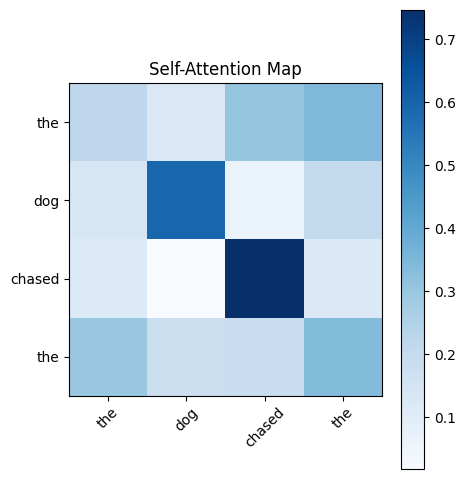

In [20]:
# 1. Select a sample input from your training data
ex_ix = 0  # or any valid index into your windowed input dataset
input_ids = inputs[ex_ix]                          # e.g., [2, 3, 4, 2]
tokens = [idx2word[i] for i in input_ids]          # Human-readable tokens

model.eval()
x_example = torch.tensor([input_ids], dtype=torch.long)  # [batch, seq]

with torch.no_grad():
    logits, attn_weights = model(x_example)

# 3. Plot attention map before OR after training
plot_attention(attn_weights, tokens, title="Self-Attention Map")

### 2.4 The Training Loop

Now that you have your model, data, and attention visualization tools ready, it’s time to train your model!  
You’ll use a classic PyTorch training loop that:

- Batches your data for efficient processing,
- Runs each batch through the model,
- Uses the loss function to measure how well your model predicts the next word,
- Updates the model parameters using the Adam optimizer,
- And tracks your progress using a live progress bar.

As the epochs progress, you should see the average loss drop—evidence that your model is learning to predict the next word given context!

In [21]:
def train_model(model, loader, loss_fn, optimizer, epochs=20, device='cpu'):
    model.to(device)
    for epoch in range(epochs):
        model.train()                  # Set the model to training mode (enables dropout/training behaviors)
        total_loss = 0
        with tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for xb, yb in pbar:
                xb, yb = xb.to(device), yb.to(device)  # Move mini-batch to the right device
                optimizer.zero_grad()                  # Clear previous gradients
                logits, _ = model(xb)                  # Forward pass for this batch
                loss = loss_fn(logits, yb)             # Calculate loss for this batch
                loss.backward()                        # Compute gradients
                optimizer.step()                       # Update model weights
                total_loss += loss.item() * xb.size(0) # Accumulate total loss for averaging
                pbar.set_postfix(loss=loss.item())     # Show live loss in the tqdm bar
        avg_loss = total_loss / len(loader.dataset)    # Average loss for entire dataset
        print(f"Epoch {epoch+1}: avg loss = {avg_loss:.4f}")

In [22]:
# Example usage:
optimizer = optim.Adam(model.parameters(), lr=0.01)     # Adam is a popular optimizer for NLP
loss_fn = nn.CrossEntropyLoss()                         # Classic loss for next-token prediction

# Assume 'loader' is your DataLoader for (input_window, target_next_token) pairs,
# and 'device' is set to "cuda" if available, else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(model, loader, loss_fn, optimizer, epochs=25, device=device)

Epoch 1/25: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s, loss=2.38]


Epoch 1: avg loss = 2.3780


Epoch 2/25: 100%|██████████| 1/1 [00:00<00:00, 248.33it/s, loss=2.21]


Epoch 2: avg loss = 2.2094


Epoch 3/25: 100%|██████████| 1/1 [00:00<00:00, 180.73it/s, loss=2.05]


Epoch 3: avg loss = 2.0505


Epoch 4/25: 100%|██████████| 1/1 [00:00<00:00, 304.73it/s, loss=1.88]


Epoch 4: avg loss = 1.8800


Epoch 5/25: 100%|██████████| 1/1 [00:00<00:00, 232.42it/s, loss=1.7]


Epoch 5: avg loss = 1.6992


Epoch 6/25: 100%|██████████| 1/1 [00:00<00:00, 210.29it/s, loss=1.52]


Epoch 6: avg loss = 1.5152


Epoch 7/25: 100%|██████████| 1/1 [00:00<00:00, 198.22it/s, loss=1.34]


Epoch 7: avg loss = 1.3380


Epoch 8/25: 100%|██████████| 1/1 [00:00<00:00, 230.32it/s, loss=1.18]


Epoch 8: avg loss = 1.1776


Epoch 9/25: 100%|██████████| 1/1 [00:00<00:00, 240.13it/s, loss=1.04]


Epoch 9: avg loss = 1.0416


Epoch 10/25: 100%|██████████| 1/1 [00:00<00:00, 319.25it/s, loss=0.934]


Epoch 10: avg loss = 0.9337


Epoch 11/25: 100%|██████████| 1/1 [00:00<00:00, 241.22it/s, loss=0.853]


Epoch 11: avg loss = 0.8528


Epoch 12/25: 100%|██████████| 1/1 [00:00<00:00, 286.57it/s, loss=0.795]


Epoch 12: avg loss = 0.7951


Epoch 13/25: 100%|██████████| 1/1 [00:00<00:00, 259.08it/s, loss=0.755]


Epoch 13: avg loss = 0.7552


Epoch 14/25: 100%|██████████| 1/1 [00:00<00:00, 197.65it/s, loss=0.728]


Epoch 14: avg loss = 0.7278


Epoch 15/25: 100%|██████████| 1/1 [00:00<00:00, 256.96it/s, loss=0.709]


Epoch 15: avg loss = 0.7091


Epoch 16/25: 100%|██████████| 1/1 [00:00<00:00, 277.95it/s, loss=0.696]


Epoch 16: avg loss = 0.6964


Epoch 17/25: 100%|██████████| 1/1 [00:00<00:00, 229.88it/s, loss=0.688]


Epoch 17: avg loss = 0.6877


Epoch 18/25: 100%|██████████| 1/1 [00:00<00:00, 271.28it/s, loss=0.681]


Epoch 18: avg loss = 0.6813


Epoch 19/25: 100%|██████████| 1/1 [00:00<00:00, 256.44it/s, loss=0.675]


Epoch 19: avg loss = 0.6751


Epoch 20/25: 100%|██████████| 1/1 [00:00<00:00, 223.76it/s, loss=0.667]


Epoch 20: avg loss = 0.6668


Epoch 21/25: 100%|██████████| 1/1 [00:00<00:00, 271.69it/s, loss=0.654]


Epoch 21: avg loss = 0.6542


Epoch 22/25: 100%|██████████| 1/1 [00:00<00:00, 246.80it/s, loss=0.635]


Epoch 22: avg loss = 0.6353


Epoch 23/25: 100%|██████████| 1/1 [00:00<00:00, 234.92it/s, loss=0.608]


Epoch 23: avg loss = 0.6078


Epoch 24/25: 100%|██████████| 1/1 [00:00<00:00, 235.56it/s, loss=0.571]


Epoch 24: avg loss = 0.5706


Epoch 25/25: 100%|██████████| 1/1 [00:00<00:00, 248.17it/s, loss=0.526]

Epoch 25: avg loss = 0.5258


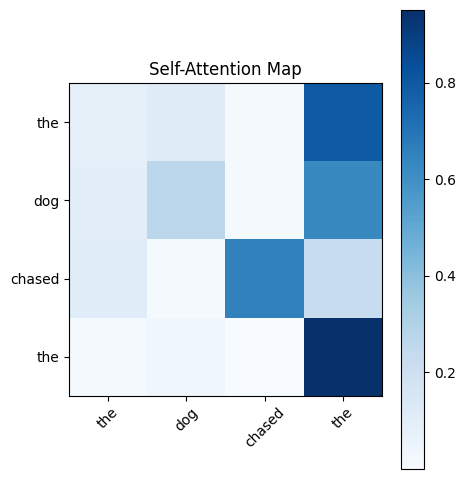

In [23]:
# 1. Select a sample input from your training data
ex_ix = 0  # or any valid index into your windowed input dataset
input_ids = inputs[ex_ix]                          # e.g., [2, 3, 4, 2]
tokens = [idx2word[i] for i in input_ids]          # Human-readable tokens

model.eval()
x_example = torch.tensor([input_ids], dtype=torch.long, device = device)  # [batch, seq]

with torch.no_grad():
    logits, attn_weights = model(x_example)

# 3. Plot attention map before OR after training
plot_attention(attn_weights, tokens, title="Self-Attention Map")

In the input sequence—"the dog chased the"—the model starts by assigning relatively even attention to all tokens, meaning each word's new representation is influenced by almost all other words. This is shown in the first (before training) map, where each row has smoothly distributed blues, and no single cell stands out.

However, after training, the map changes dramatically: you see much darker squares in particular positions of each row. For example, the first "the" might now strongly attend to "dog" while "dog" might heavily attend to "chased" and so on. What this means is that the model has learned, through exposure to many sentence patterns, that certain words in this context are especially important for predicting or understanding others. 

In practical terms:  
- When the model processes "the" it recognizes from training that "dog" is the most relevant context in this position—perhaps because "the dog" is a frequent phrase structure.
- When it processes "dog" it attends more strongly to "chased" learning that verbs often follow nouns in your data.
- The strong attention from the last "the" to "dog" (or "chased" depending on weights) reflects the model's understanding of typical sentence continuations in this specific dataset.

So, this focused attention after training visually confirms that the self-attention mechanism has picked up on real relationships in your sentence structure, allowing the model to make smarter predictions by leveraging learned language patterns, not just treating all words equally.

### 2.5 Predicting Multiple Next Words

After training, you want to see your model in action—not just on a single token, but generating entire continuations from a given prompt.

The function below takes a starting sentence, uses your tokenizer to split it into tokens, and then generates as many new words as you want, one at a time. Each prediction uses the most recent `seq_len` words as context, just like during training. The function maps between words and token IDs using your vocabulary.

This allows you to explore how your self-attention model “writes” language, step by step!

In [24]:
def generate_next_words(model, sentence, tokenizer, word2idx, idx2word, max_tokens=5, seq_len=4, device='cpu'):
    """
    Given an input sentence (string), tokenize it and generate the next `max_tokens` words.
    - model: trained self-attention model
    - sentence: the starting sequence, as a raw string
    - tokenizer: function to split sentence into tokens
    - word2idx, idx2word: vocab dicts for conversions
    - seq_len: length of context window, should match model/data
    - device: 'cpu' or 'cuda'
    """
    model.eval()                         # Set model to evaluation mode (turn off dropout etc.)
    generated = tokenizer(sentence)      # Tokenize the input sentence

    for _ in range(max_tokens):
        # Prepare the context window (most recent seq_len tokens, pad left if needed)
        window = generated[-seq_len:] if len(generated) >= seq_len \
                 else ['<pad>'] * (seq_len - len(generated)) + generated

        # Convert tokens to their indices (IDs) for the model
        input_ids = torch.tensor([[word2idx.get(w, word2idx['<unk>']) for w in window]], dtype=torch.long).to(device)

        # Model predicts logits for the next word
        with torch.no_grad():
            logits, _ = model(input_ids)
            next_id = logits.argmax(dim=-1).item()          # Use the most probable word

        next_word = idx2word[next_id]                       # Convert ID back to word
        generated.append(next_word)                         # Append prediction to the sequence

    return generated

In [25]:
# Example usage:
sentence = "the dog chased the"
output = generate_next_words(model, sentence, tokenizer, word2idx, idx2word, max_tokens=1, seq_len=SEQ_LEN, device=device)
print("Generated sequence:", " ".join(output))

Generated sequence: the dog chased the cat


## 3 - To Train, or Not to Train: A Shakespeare Generator Example

Now you’ll put all the pieces together for a real application:  
a mini “Shakespeare Generator” trained on actual lines from the Bard’s plays.

In this section, you’ll apply your attention-based model to generate new Shakespearean text.  
You'll use the tools and code you built above to:

- Prepare and encode the Shakespeare dataset
- Train your self-attention model on it
- Generate new lines of “Shakespeare” by predicting multiple words from a chosen prompt

Let’s see how your custom transformer becomes a playwright!

### 3.1 Data Preparation

To train your model on real Shakespearean language, you first need to get the dataset and inspect its format. In this step, you’ll automatically download a classic, open-source collection of Shakespeare’s works if it’s not already present. You’ll also peek at the start of the file to understand the kind of text you’re working with.

This raw text will form the basis for all your training and generation experiments.

In [26]:
# Download if needed
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tiny input.txt"
filename = "shakespeare.txt"

# Check if file already exists
if os.path.exists(filename):
    print(f"'{filename}' already exists, skipping download.")
else:
    print(f"Downloading '{filename}'...")
    urllib.request.urlretrieve(url, filename)
    print(f"Download complete!")

# Read the text
with open(filename, "r", encoding="utf-8") as f:
    text = f.read()

print(text[:300])  # Just peek at the start

'shakespeare.txt' already exists, skipping download.
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


Next, you’ll need to split Shakespeare’s text into tokens so your model can process it.  
This custom tokenizer is designed to:

- Replace every line break (`\n`) with a special `<nl>` token, so your model can learn line boundaries or poetic structure if needed.
- Split the text into words (including contractions), standalone punctuation marks, and `<nl>` as individual tokens.

This approach gives your model clear, structured input ready for building a vocabulary and training.

In [27]:
class ShakespeareTokenizer:
    def __call__(self, text):
        # Replace line breaks with a special token
        text = text.replace('\n', ' <nl> ')
        # Tokenize words, contractions, <nl>, and punctuation
        return re.findall(r"\w+(?:'\w+)?|<nl>|[^\w\s]", text)

In [28]:
# Instantiate your tokenizer
tokenizer = ShakespeareTokenizer()

# Build vocabulary from all Shakespeare lines using your tokenizer
vocab, word2idx, idx2word = build_vocab([text], tokenizer, min_freq=1)
print("Vocab size:", len(vocab))
print("First 20 vocab words:", vocab[:20])

Vocab size: 14300
First 20 vocab words: ['<pad>', '<unk>', 'First', 'Citizen', ':', '<nl>', 'Before', 'we', 'proceed', 'any', 'further', ',', 'hear', 'me', 'speak', '.', 'All', 'Speak', 'You', 'are']


To prepare your data for training, you need to break up the full Shakespeare text into many (input, target) pairs using a **sliding window** approach:

- Each input consists of a sequence of `SEQ_LEN` consecutive tokens.
- The target is the immediate next token that follows this window in the text.

By sliding this window over the entire dataset, you create thousands of training pairs that help your model learn the flow and structure of real language—even across line breaks and scene changes.

Below, you’ll build these pairs and print out an example to see exactly what your model will use as context and what it's being trained to predict.

In [29]:
SEQ_LEN = 25
tokens = tokenizer(text)    # Tokenize the full text as one sequence!
inputs = []
targets = []
for i in range(len(tokens) - SEQ_LEN):
    window = tokens[i:i+SEQ_LEN]
    target = tokens[i+SEQ_LEN]
    input_ids = [word2idx.get(w, word2idx['<unk>']) for w in window]
    target_id = word2idx.get(target, word2idx['<unk>'])
    inputs.append(input_ids)
    targets.append(target_id)
        
print("Number of (input, target) pairs:", len(inputs))
print("Example input:", [idx2word[i] for i in inputs[0]])
print("Example target:", idx2word[targets[0]])

Number of (input, target) pairs: 293574
Example input: ['First', 'Citizen', ':', '<nl>', 'Before', 'we', 'proceed', 'any', 'further', ',', 'hear', 'me', 'speak', '.', '<nl>', '<nl>', 'All', ':', '<nl>', 'Speak', ',', 'speak', '.', '<nl>', '<nl>']
Example target: First


### 3.2 Building The Dataset

With your `(input, target)` pairs ready, you now need to convert them into a format that's easy for PyTorch to use during training.

By defining a custom `ShakespeareDataset`, you make sure each example is quickly and reliably available by index, allowing PyTorch's `DataLoader` to:
- batch sequences together,
- shuffle the training data,
- and prepare everything for efficient model training.

This setup is not only standard for PyTorch workflows, but also makes scaling up to bigger datasets or experiments much easier.

In [30]:
class ShakespeareDataset(Dataset):
    def __init__(self, inputs, targets):
        # Store inputs and targets as PyTorch tensors for fast indexing
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.inputs)  # Number of samples in the dataset

    def __getitem__(self, idx):
        # Return (input_window, target) tuple for the given index
        return self.inputs[idx], self.targets[idx]

dataset = ShakespeareDataset(inputs, targets)
loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
vocab_size = len(vocab)  # Store vocab size for easy reference

### 3.3 PyTorch Multihead Attention

Up to this point, you've manually implemented every piece of self-attention, giving you a deep, hands-on understanding of how it works. Now, you'll take the next step towards building state-of-the-art models: using PyTorch's built-in `nn.MultiheadAttention` layer.

Why use the built-in layer instead of your manual version?
- **Efficiency:** PyTorch's implementation is highly optimized and leveraged in real production models.
- **Complexity:** The built-in module supports multi-head attention out of the box, allowing your model to learn multiple types of linguistic relationships in parallel—something that gets cumbersome to code by hand.
- **Scalability:** You can easily adjust the number of heads, dropout, or embedding size, and take advantage of GPU acceleration and batched computation.
- **Compatibility:** This layer is the exact one used in modern transformers, making it easy to transition your knowledge and code to larger or more sophisticated projects.

<details>
<summary><b>How Attention Works (Formula Explanation)</b></summary>

Self-attention for a sequence is computed as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right) V
$$

Where:

- $Q = X W^Q$ are the query vectors,
- $K = X W^K$ are the key vectors,
- $V = X W^V$ are the value vectors,
- $X$ is the input matrix (sequence of embeddings),
- $W^Q, W^K, W^V$ are the learned projection matrices,
- $d_k$ is the dimension of the key/query,
- The output is a weighted sum of the value vectors, with weights determined by the similarity (dot product) between queries and keys.

For multi-head attention, you concatenate several such outputs (with parallel projections), and then linearly project again to the original embedding size.

</details>


Below, you'll see how easy it is to swap out your custom self-attention for PyTorch’s flexible, production-level multi-head attention layer.

In [31]:
class SelfAttnWithMHA(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        # Embedding layer: maps each token ID to a vector of size embed_dim
        self.tok_embed = nn.Embedding(vocab_size, embed_dim)
        # Positional embedding: lets the model know the order of words in the sequence
        self.pos_embed = nn.Embedding(seq_len, embed_dim)
        # Built-in PyTorch Multi-Head Self-Attention
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,      # Size of embeddings/hidden states
            num_heads=num_heads,      # How many attention 'heads' to use in parallel
            dropout=dropout,          # Dropout on attention weights for regularization
            batch_first=True          # Data shape will be (batch, seq, embed_dim)
        )
        # Linear layer to map attention output to vocab size (scores for next-word prediction)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, token_ids):
        # token_ids: shape [batch_size, seq_len], where each entry is a word index
        batch_size, seq_len = token_ids.shape
        # Compute position indices for each token in the batch
        positions = torch.arange(seq_len, device=token_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        # Get word embeddings and add position embeddings (to encode word order)
        input_vecs = self.tok_embed(token_ids) + self.pos_embed(positions)  # Shape: [batch, seq, embed_dim]
        # Apply multihead self-attention: computes how each word in the sequence attends to every other word
        # Inputs q/k/v are all input_vecs for self-attention
        attn_out, attn_w = self.attn(input_vecs, input_vecs, input_vecs, need_weights=True)
        # Take the output corresponding to the last token (predict the next word after the sequence)
        last_hidden = attn_out[:, -1, :]  # Shape: [batch, embed_dim]
        # Final linear layer: outputs scores (logits) for each possible next word in the vocab
        logits = self.fc(last_hidden)     # Shape: [batch, vocab_size]
        # Return logits and attention weights (for visualization or interpretation)
        return logits, attn_w

In [32]:
model = SelfAttnWithMHA(vocab_size=vocab_size, seq_len=SEQ_LEN)
# Create a new instance of your (multi-head attention) model, sized to your vocab and sequence length

loss_fn = nn.CrossEntropyLoss()  
# Define the loss function (CrossEntropy is standard for language modeling);
# Redefine here to ensure it's fresh and configured for your current task

optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the optimizer (Adam adjusts model parameters during training);
# Always recreate the optimizer after making a new model, or when model params change

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
# Select GPU ("cuda") if available, otherwise use CPU

model.to(device)
# Move your model’s parameters to the chosen device (CPU or GPU)

torch.cuda.empty_cache()
# (Optional) Clear unused memory from the GPU to avoid memory leaks or OOM errors;
# Especially useful if you ran a different model before in the same session

In [33]:
# Example usage:
sentence = "to be or not"
output = generate_next_words(model, sentence, tokenizer, word2idx, idx2word, max_tokens=50, seq_len=SEQ_LEN, device=device)
print("Generated sequence:", " ".join(output))

Generated sequence: to be or not value value value blushes sufficiently value fleshmonger value fleshmonger camel camel camel camel camel By'r seventy brawl smoke sinn'd seventy seventy seventy seventy seventy seventy seventy seventy seventy seventy seventy seventy knock'd knock'd knock'd knock'd knock'd knock'd ensky'd ensky'd dry knock'd knock'd loathed knock'd ensky'd ensky'd ensky'd dry suit's Leicester


### 3.4 Training Your Attention Model

Now you’re ready to train your multi-head attention language model!  
This function wraps the entire training process: it takes batches from your DataLoader, computes the model’s predictions, compares them to the true next words using the loss function, and updates the model’s parameters using the optimizer.  
You’ll see a progress bar for each epoch, along with average loss—which should go down as your model learns from the data.

Run the cell below to begin training. You can increase the number of epochs to achieve better performance, but keep in mind that this will also increase the training time.

In [34]:
def train_model(model, loader, loss_fn, optimizer, epochs=10, device='cpu', vocab_size=None):
    model.to(device)  # Ensure model is on the right device (CPU or GPU)
    for epoch in range(epochs):
        model.train()  # Set to training mode (important for some layers)
        total_loss = 0
        n_batches = len(loader)
        with tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for xb, yb in pbar:
                xb, yb = xb.to(device), yb.to(device)    # Move batch to correct device
                optimizer.zero_grad()                    # Clear previous gradients
                logits, _ = model(xb)                    # Forward pass: get model predictions and attention
                loss = loss_fn(logits, yb)               # Compute loss
                loss.backward()                          # Backpropagation: compute gradients
                optimizer.step()                         # Update the model's parameters
                total_loss += loss.item() * xb.size(0)   # Accumulate total loss for reporting
                pbar.set_postfix(loss=loss.item())       # Show current batch loss in progress bar

        avg_loss = total_loss / len(loader.dataset)
        print(f"Epoch {epoch+1:2d}: avg loss = {avg_loss:.4f}")

# Usage:
EPOCHS = 5
vocab_size = len(vocab)  # Pass this in!
train_model(model, loader, loss_fn, optimizer, epochs=EPOCHS, device=device, vocab_size=vocab_size)

Epoch 1/5: 100%|██████████| 2294/2294 [00:43<00:00, 52.33it/s, loss=4.24]


Epoch  1: avg loss = 5.4737


Epoch 2/5: 100%|██████████| 2294/2294 [00:42<00:00, 54.38it/s, loss=5.58]


Epoch  2: avg loss = 4.9606


Epoch 3/5: 100%|██████████| 2294/2294 [00:42<00:00, 54.39it/s, loss=4.69]


Epoch  3: avg loss = 4.5892


Epoch 4/5: 100%|██████████| 2294/2294 [00:42<00:00, 53.42it/s, loss=5.18]


Epoch  4: avg loss = 4.3086


Epoch 5/5: 100%|██████████| 2294/2294 [00:52<00:00, 44.04it/s, loss=4.24]

Epoch  5: avg loss = 4.0841


When you trained your model, you used a special token `<nl>` to represent newlines (line breaks) in the Shakespeare dataset.  
This allowed your tokenizer and model to recognize and generate line boundaries just like any other word.

However, when you actually want to read or display the generated text, you want to see real line breaks—not the literal string `<nl>`.  
That's why, in the generation function, you replace every occurrence of `<nl>` with the actual newline character `\n`.  
This makes your generated samples readable and visually closer to real Shakespearean poetry or drama!

In other words:  
- **Inside the model:** `<nl>` acts as a "word" that teaches your network where lines start and end.  
- **Outside the model:** you convert `<nl>` back to a true line break so your output looks natural.

This small transformation turns a list like  
`["to", "be", "<nl>", "or", "not", "<nl>", "to", "be"]`  
into something that prints as  
```
to be
or not
to be
```

In [35]:
# A small helper class to generate next words from a model with temperature sampling.


class NextWordGenerator:
    """
    Generate next tokens from a language model using a fixed context window and temperature sampling.

    - Uses left-padding with <pad> to fill the initial context window.
    - Applies temperature scaling to logits, then samples with multinomial.
    - Converts special <nl> token to '\n' in the final output.
    """

    def __init__(
        self,
        model: nn.Module,
        tokenizer: Callable[[str], Sequence[str]],
        word2idx: Dict[str, int],
        idx2word: Dict[int, str],
        *,
        seq_len: int = 6,
        device: str = "cpu",
        pad_token: str = "<pad>",
        unk_token: str = "<unk>",
        nl_token: str = "<nl>",
    ) -> None:
        self.model = model
        self.tokenizer = tokenizer
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.seq_len = seq_len
        self.device = device
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.nl_token = nl_token

        # Cache common ids
        self._unk_id = self.word2idx[self.unk_token]

    def _make_window(self, generated: List[str]) -> List[str]:
        if len(generated) >= self.seq_len:
            return generated[-self.seq_len:]
        pad_count = self.seq_len - len(generated)
        return [self.pad_token] * pad_count + generated

    def _encode(self, tokens: Sequence[str]) -> torch.Tensor:
        ids = [self.word2idx.get(t, self._unk_id) for t in tokens]
        return torch.tensor([ids], dtype=torch.long, device=self.device)

    def _decode_id(self, idx: int) -> str:
        return self.idx2word[idx]

    def _postprocess(self, tokens: List[str]) -> List[str]:
        # Replace <nl> with actual newlines for display/printing
        return [("\n" if t == self.nl_token else t) for t in tokens]

    def generate(
        self,
        sentence: str,
        *,
        max_tokens: int = 20,
        temperature: float = 1.0,
    ) -> List[str]:
        """
        Generate up to `max_tokens` tokens continuing from `sentence`.
        Returns the full sequence including the original tokens, with <nl> converted to '\n'.
        """
        if temperature <= 0:
            raise ValueError("temperature must be > 0")

        self.model.eval()
        generated = list(self.tokenizer(sentence))  # mutate in place; no need to copy

        with torch.no_grad():
            for _ in range(max_tokens):
                window = self._make_window(generated)
                input_ids = self._encode(window)

                logits, _ = self.model(input_ids)  # expects shape [1, vocab]
                logits = logits / temperature
                probs = torch.softmax(logits, dim=-1)

                # Sample the next token id; returns shape [1, 1]
                next_id = torch.multinomial(probs, num_samples=1).item()
                next_token = self._decode_id(next_id)
                generated.append(next_token)

        return self._postprocess(generated)

In [36]:
# Example usage:
generator = NextWordGenerator(
    model=model,
    tokenizer=tokenizer,
    word2idx=word2idx,
    idx2word=idx2word,
    seq_len=SEQ_LEN,
    device=device,
)

output = generator.generate("To be or not to", max_tokens=50, temperature=1.0)
print("Generated sequence:", " ".join(output))

Generated sequence: To be or not to all my ! 
 I'll with Warwick , we in such the wall , 
 And since she will be golden habited that throne from 
 LORD workmanly if the punishment of happy , will prove 
 separation . 
 
 GLOUCESTER : 
 He that of , they Whom


## 4 - Conclusion

In this lab, you’ve worked through every step of building a modern attention-based language model from scratch:
- You started by preparing your text data, creating a vocabulary, and organizing your dataset using sliding windows.
- You implemented self-attention both manually and using PyTorch’s powerful `nn.MultiheadAttention` layer, learning exactly how these models “pay attention” to context.
- You trained your model on real Shakespearean language, and were able to generate new text—sometimes even capturing the style and rhythm of the Bard himself!

By working hands-on with both custom and built-in attention, you gained a deep understanding of what makes transformers so effective in modern NLP:
- The ability to learn flexible, context-dependent relationships within text;
- The scalability and practicality of using optimized library components;
- The importance of good data preparation and robust, interpretable generation.

Keep exploring! Try different seeds, experiment with model hyperparameters, or dive deeper into visualizing attention maps.  